In [129]:
import os
import json
import matplotlib.pyplot as plt
import pandas as pd
import pickle as pkl
import networkx as nx
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np
import re
#plt.style.use('seaborn-whitegrid')

In [130]:
import matplotlib
font = {'size'   : 13}

matplotlib.rc('font', **font)

In [131]:
SAVE_PATH = "../output/facebook_4000_final_experiments_5rep"
DATA_PATH = "../data/facebook_4000.gml"
graph_name = "facebook_4000"
output_fig = "{}_fig".format(graph_name)

In [132]:
if not os.path.exists(output_fig):
    os.makedirs(output_fig)
else:
    print("Careful, might overwrite")

Careful, might overwrite


In [133]:
G = nx.read_gml(DATA_PATH)
print("Graph : ", DATA_PATH)
print("Number of nodes : {}  -  Number of edges : {}\n".format(G.number_of_nodes(), G.number_of_edges()))
kcores = nx.core_number(G)
max_core_index = max(kcores.values())

Graph :  ../data/facebook_4000.gml
Number of nodes : 4039  -  Number of edges : 88234



### Util functions

In [134]:
def get_emb_params(save_path, exp_name):
    with open(os.path.join(save_path, exp_name, "embedder_params.json"), "r") as f:
        params = json.load(f)
    return params

def get_sub_emb_params(save_path, exp_name):
    with open(os.path.join(save_path, exp_name, "sub_embedder_params.json"), "r") as f:
        params = json.load(f)
    return params

def get_config_params(save_path, exp_name):
    with open(os.path.join(save_path, exp_name, "script_args.json"), "r") as f:
        params = json.load(f)
    return params

def get_exp_results(save_path, exp_name) -> pd.DataFrame:
    results = pd.read_csv(os.path.join(save_path, exp_name, "base_metrics.csv"))
    results["exec_times"] = results["exec_times"].apply(lambda time_dict : eval(time_dict))
    return results

In [135]:
def fname_fn(name, output_fig=output_fig):
    return os.path.join(os.path.join(output_fig, "{}.png".format(name)))

In [136]:
cum_core_number_fn = lambda index: len(list(filter(lambda x: x[1]<=index, kcores.items())))

# Link prediction - cut ratio : 10%

In [137]:
exp_names = [x for x in os.listdir(SAVE_PATH) if re.match(graph_name+"_k_core*", x)]

core_index = []
f1_score = []
f1_score_std = []
exec_time = []
exec_time_std = []
cut_ratio = []
core_dec_time = []
propag_time = []
embed_time = []

for exp_name in exp_names :
    try :
        params = get_emb_params(SAVE_PATH, exp_name)
        results = get_exp_results(SAVE_PATH, exp_name)
        config = get_config_params(SAVE_PATH, exp_name)
        cut_ratio_ = config["downstream_task_args"]["cut_ratio"]
        if cut_ratio_ != .1:
            continue
        cut_ratio.append(cut_ratio_)
        core_index.append(params["train"]["core_index"])
        f1_score.append(results["macro_f1"].mean())
        f1_score_std.append(results["macro_f1"].std())
        
        exec_time.append(results["exec_times"].apply(lambda x: x["total"]).mean())
        exec_time_std.append(results["exec_times"].apply(lambda x: x["total"]).std())
        
        core_dec_time.append(results["exec_times"].apply(lambda x: x["k_core"]).mean())
        propag_time.append(results["exec_times"].apply(lambda x: x["propagate"]).mean())
        embed_time.append(results["exec_times"].apply(lambda x: x["embed"]).mean())
        
    except FileNotFoundError:
        pass
        

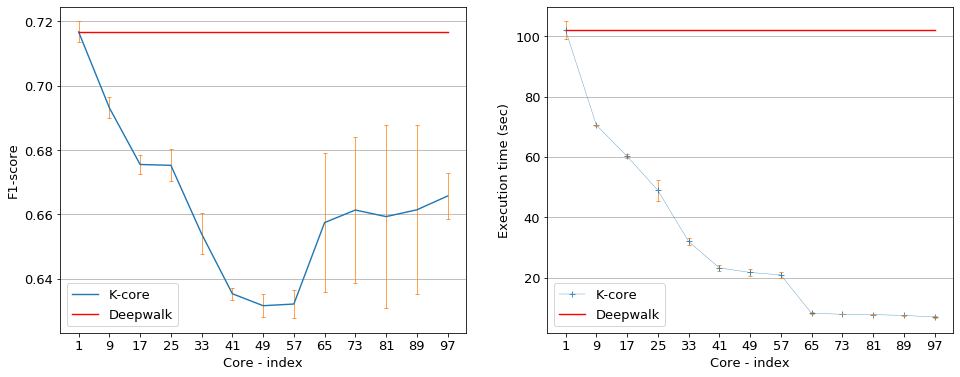

In [138]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)

error_plot_args = {"alpha":.8, "lw":0, "marker":"", "elinewidth":.9, "capsize":2}
plt.plot(sorted(core_index), np.array(f1_score)[np.argsort(core_index)], label = "K-core", lw=1.4)
plt.errorbar(sorted(core_index), np.array(f1_score)[np.argsort(core_index)], yerr=np.array(f1_score_std)[np.argsort(core_index)], **error_plot_args)
plt.plot(sorted(core_index), [np.array(f1_score)[np.argsort(core_index)][0]]*len(core_index), label="Deepwalk", lw=1.4, c="r")
plt.ylabel("F1-score")
plt.xlabel("Core - index")
plt.legend()
plt.xticks(core_index)
plt.gca().yaxis.grid(True)

plt.subplot(1, 2, 2)

plt.plot(sorted(core_index), np.array(exec_time)[np.argsort(core_index)], marker="+", alpha=.8, lw=.4, label = "K-core")
plt.errorbar(sorted(core_index), np.array(exec_time)[np.argsort(core_index)], yerr=np.array(exec_time_std)[np.argsort(core_index)], **error_plot_args)
plt.plot(sorted(core_index), [np.array(exec_time)[np.argsort(core_index)][0]]*len(core_index), label="Deepwalk", lw=1.4, c="r")
plt.ylabel("Execution time (sec)")
plt.xlabel("Core - index")
plt.legend()
plt.xticks(core_index)
plt.gca().yaxis.grid(True)

plt.savefig(fname_fn("facebook_10p_f1_exec"), dpi=600, bbox_inches="tight")

plt.show()



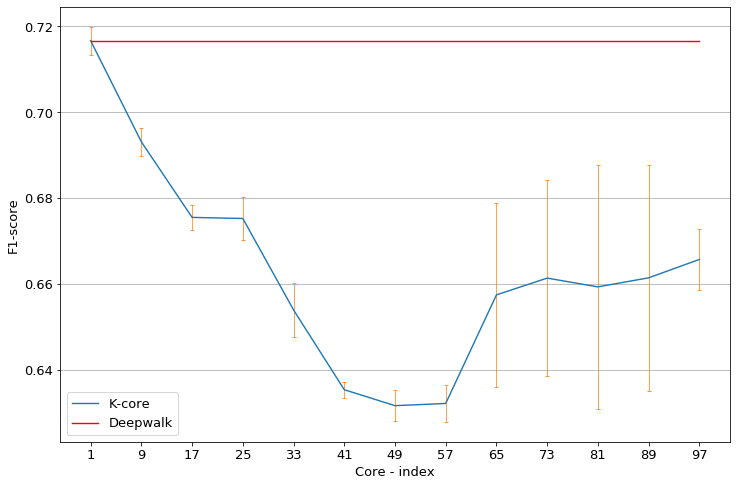

In [139]:
fig = plt.figure(figsize=(12, 8))
plt.subplot(1, 1, 1)

error_plot_args = {"alpha":.8, "lw":0, "marker":"", "elinewidth":.9, "capsize":2}
plt.plot(sorted(core_index), np.array(f1_score)[np.argsort(core_index)], label = "K-core", lw=1.4)
plt.errorbar(sorted(core_index), np.array(f1_score)[np.argsort(core_index)], yerr=np.array(f1_score_std)[np.argsort(core_index)], **error_plot_args)
plt.plot(sorted(core_index), [np.array(f1_score)[np.argsort(core_index)][0]]*len(core_index), label="Deepwalk", lw=1.4, c="r")
plt.ylabel("F1-score")
plt.xlabel("Core - index")
plt.legend()
plt.xticks(core_index)
plt.gca().yaxis.grid(True)

plt.savefig(fname_fn("facebook_10p_f1"), dpi=600, bbox_inches="tight")

plt.show()

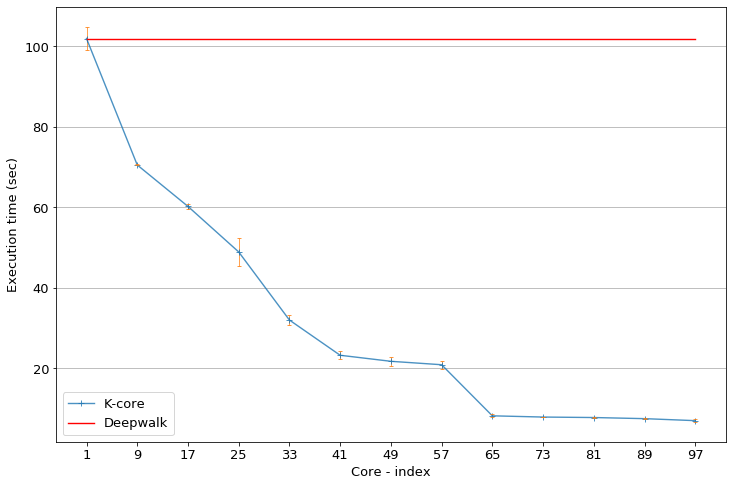

In [140]:
fig = plt.figure(figsize=(12, 8))
plt.subplot(1, 1, 1)

plt.plot(sorted(core_index), np.array(exec_time)[np.argsort(core_index)], marker="+", alpha=.8, lw=1.4, label = "K-core")
plt.errorbar(sorted(core_index), np.array(exec_time)[np.argsort(core_index)], yerr=np.array(exec_time_std)[np.argsort(core_index)], **error_plot_args)
plt.plot(sorted(core_index), [np.array(exec_time)[np.argsort(core_index)][0]]*len(core_index), label="Deepwalk", lw=1.4, c="r")
plt.ylabel("Execution time (sec)")
plt.xlabel("Core - index")
plt.legend()
plt.xticks(core_index)
plt.gca().yaxis.grid(True)

plt.savefig(fname_fn("facebook_10p_exec_time"), dpi=600, bbox_inches="tight")

plt.show()

In [141]:
cum_core_nodes = np.array([cum_core_number_fn(k) for k in range(1, max_core_index+1)])[np.array(sorted(core_index))-1]

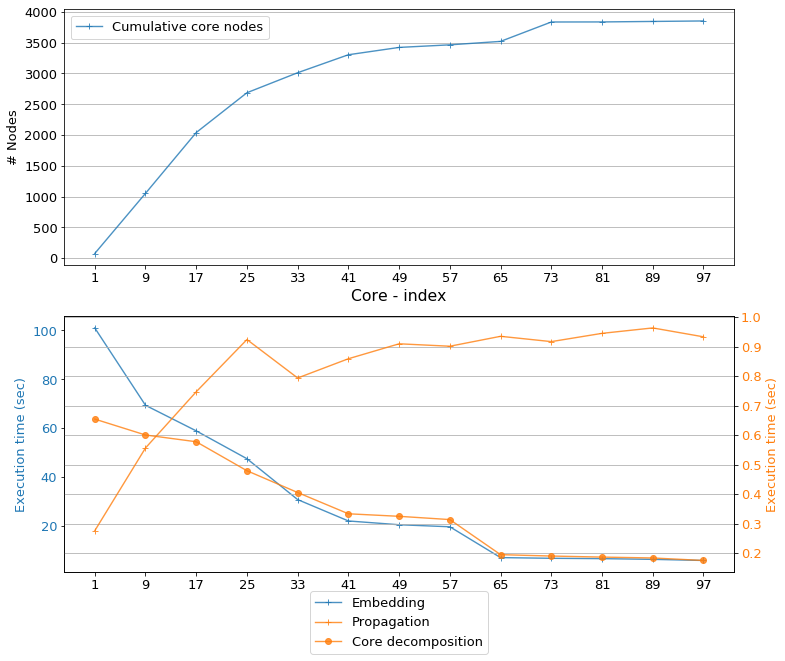

In [142]:
plt.figure(figsize=(12, 16))
plt.subplot(3, 1, 1)

plt.plot(sorted(core_index), cum_core_nodes, marker="+", alpha=.8, lw=1.4, label = "Cumulative core nodes")

plt.ylabel("# Nodes")
plt.xlabel("Core - index", fontsize="large")
plt.legend()
plt.xticks(core_index)
plt.gca().yaxis.grid(True)

ax1 = plt.subplot(3, 1, 2)
l1 = ax1.plot(sorted(core_index), np.array(embed_time)[np.argsort(core_index)], marker="+", alpha=.8, lw=1.4, label = "Embedding")
ax1.set_ylabel("Execution time (sec)", color="C0")
ax1.tick_params(axis='y', labelcolor="C0")

ax2 = ax1.twinx()

ax2.set_ylabel("Execution time (sec)", color="C1")
l2 = ax2.plot(sorted(core_index), np.array(propag_time)[np.argsort(core_index)], marker="+", alpha=.8, lw=1.4, label = "Propagation", color="C1")
l3 = ax2.plot(sorted(core_index), np.array(core_dec_time)[np.argsort(core_index)], marker="o", alpha=.8, lw=1.4, label = "Core decomposition", color="C1")
ax2.tick_params(axis='y', labelcolor="C1")
plt.xlabel("Core - index", fontsize="large")
plt.xticks(core_index)
lns = l1 + l2 + l3
labels = [l.get_label() for l in lns]
ax1.legend(lns, labels, loc='upper center', bbox_to_anchor=(0.5, -0.05))
plt.gca().yaxis.grid(True)

plt.savefig(fname_fn("facebook_10p_exec_time_detail"), dpi=600, bbox_inches="tight")

plt.show()

## Embedding

In [98]:
def get_embedding(save_path, exp_name):
    base_embedding_path = os.path.join(os.path.join(save_path, exp_name), "embeddings/embeddings_base_0.pkl")
    target_embedding_path = os.path.join(os.path.join(save_path, exp_name), "embeddings/embeddings_target_0.pkl")

    with open(base_embedding_path, "rb") as fin:
        base_emb = pkl.load(fin)

    with open(target_embedding_path, "rb") as fin:
        target_emb = pkl.load(fin)
        
    return target_emb, base_emb

In [154]:
def plot_emb_core(vectors, id2node, core_numbers, min_core=0, max_core=1000):
    pca = PCA(n_components=2)
    projected_vectors = pca.fit_transform(vectors)
    id2core = [core_numbers[node] for node in id2node if min_core <= core_numbers[node] <= max_core]    
    to_be_plot = np.array([vector for i, vector in enumerate(projected_vectors) if min_core <= core_numbers[id2node[i]] <= max_core])
    plt.scatter(to_be_plot.T[0], to_be_plot.T[1], marker='.', alpha=0.5, 
               c=id2core) , cmap="plasma")
    plt.colorbar()

In [155]:
def plot_emb_core_class(vectors, id2node, core_numbers, min_core=0, max_core=1000):
    labels_dict = graph.nodes.data()
    pca = PCA(n_components=2)
    projected_vectors = pca.fit_transform(vectors)
    labels = [labels_dict[node]["community"] for node in id2node if min_core <= core_numbers[node] <= max_core]    
    to_be_plot = np.array([vector for i, vector in enumerate(projected_vectors) if min_core <= core_numbers[id2node[i]] <= max_core])
    plt.scatter(to_be_plot.T[0], to_be_plot.T[1], marker='.', alpha=0.5, 
               c=labels) #, cmap="plasma")
    # plt.colorbar()

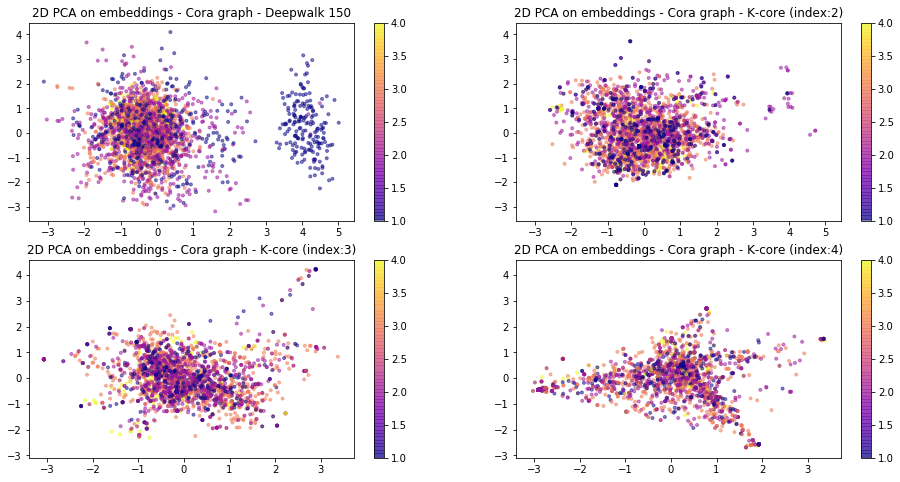

In [118]:
target_emb, base_emb = get_embedding(SAVE_PATH, exp_name)
graph = nx.read_gml(DATA_PATH)
core_numbers = nx.core_number(graph)

core_index = []
target_emb_list, base_emb_list = [], []
for exp_name in exp_names :
    params = get_exp_params(SAVE_PATH, exp_name)
    core_index.append(params["train"]["core_index"])
    target_emb, base_emb = get_embedding(SAVE_PATH, exp_name)
    target_emb_list.append(target_emb)
    base_emb_list.append(base_emb)

fig = plt.figure(figsize=(16, 8))
ax = plt.subplot(221)
vectors, node2id, id2node = base_emb.values()
plot_emb_core(vectors, id2node, core_numbers, min_core=0)  #, min_core=0, max_core=114)
plt.title("2D PCA on embeddings - Cora graph - Deepwalk 150")
plt.subplot(222, sharex=ax, sharey=ax)
vectors, node2id, id2node = target_emb_list[1].values()
plot_emb_core(vectors, id2node, core_numbers, min_core=0)
plt.title("2D PCA on embeddings - Cora graph - K-core (index:{})".format(core_index[1]))
ax = plt.subplot(223)
vectors, node2id, id2node = target_emb_list[2].values()
plot_emb_core(vectors, id2node, core_numbers, min_core=0)  #, min_core=0, max_core=114)
plt.title("2D PCA on embeddings - Cora graph - K-core (index:{})".format(core_index[2]))
plt.subplot(224, sharex=ax, sharey=ax)
vectors, node2id, id2node = target_emb_list[3].values()
plot_emb_core(vectors, id2node, core_numbers, min_core=0)
plt.title("2D PCA on embeddings - Cora graph - K-core (index:{})".format(core_index[3]))
plt.show()

# Link prediction - Cut ratio 30%

In [143]:
exp_names = [x for x in os.listdir(SAVE_PATH) if re.match(graph_name+"_k_core*", x)]

core_index = []
f1_score = []
f1_score_std = []
exec_time = []
exec_time_std = []
cut_ratio = []
core_dec_time = []
propag_time = []
embed_time = []

for exp_name in exp_names :
    try :
        params = get_emb_params(SAVE_PATH, exp_name)
        results = get_exp_results(SAVE_PATH, exp_name)
        config = get_config_params(SAVE_PATH, exp_name)
        cut_ratio_ = config["downstream_task_args"]["cut_ratio"]
        if cut_ratio_ != .3:
            continue
        cut_ratio.append(cut_ratio_)
        core_index.append(params["train"]["core_index"])
        f1_score.append(results["macro_f1"].mean())
        f1_score_std.append(results["macro_f1"].std())
        
        exec_time.append(results["exec_times"].apply(lambda x: x["total"]).mean())
        exec_time_std.append(results["exec_times"].apply(lambda x: x["total"]).std())
        
        core_dec_time.append(results["exec_times"].apply(lambda x: x["k_core"]).mean())
        propag_time.append(results["exec_times"].apply(lambda x: x["propagate"]).mean())
        embed_time.append(results["exec_times"].apply(lambda x: x["embed"]).mean())
        
    except FileNotFoundError:
        pass
        

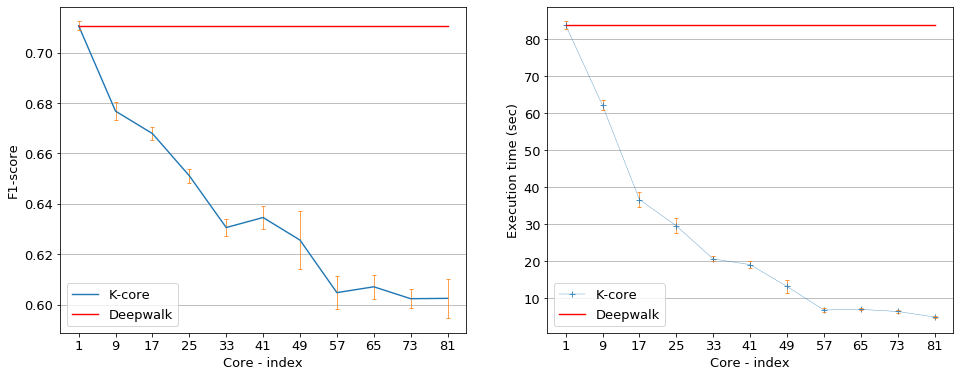

In [144]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)

error_plot_args = {"alpha":.8, "lw":0, "marker":"", "elinewidth":.9, "capsize":2}
plt.plot(sorted(core_index), np.array(f1_score)[np.argsort(core_index)], label = "K-core", lw=1.4)
plt.errorbar(sorted(core_index), np.array(f1_score)[np.argsort(core_index)], yerr=np.array(f1_score_std)[np.argsort(core_index)], **error_plot_args)
plt.plot(sorted(core_index), [np.array(f1_score)[np.argsort(core_index)][0]]*len(core_index), label="Deepwalk", lw=1.4, c="r")
plt.ylabel("F1-score")
plt.xlabel("Core - index")
plt.legend()
plt.xticks(core_index)
plt.gca().yaxis.grid(True)

plt.subplot(1, 2, 2)

plt.plot(sorted(core_index), np.array(exec_time)[np.argsort(core_index)], marker="+", alpha=.8, lw=.4, label = "K-core")
plt.errorbar(sorted(core_index), np.array(exec_time)[np.argsort(core_index)], yerr=np.array(exec_time_std)[np.argsort(core_index)], **error_plot_args)
plt.plot(sorted(core_index), [np.array(exec_time)[np.argsort(core_index)][0]]*len(core_index), label="Deepwalk", lw=1.4, c="r")
plt.ylabel("Execution time (sec)")
plt.xlabel("Core - index")
plt.legend()
plt.xticks(core_index)
plt.gca().yaxis.grid(True)

plt.savefig(fname_fn("facebook_30p_f1_exec"), dpi=600, bbox_inches="tight")
plt.show()


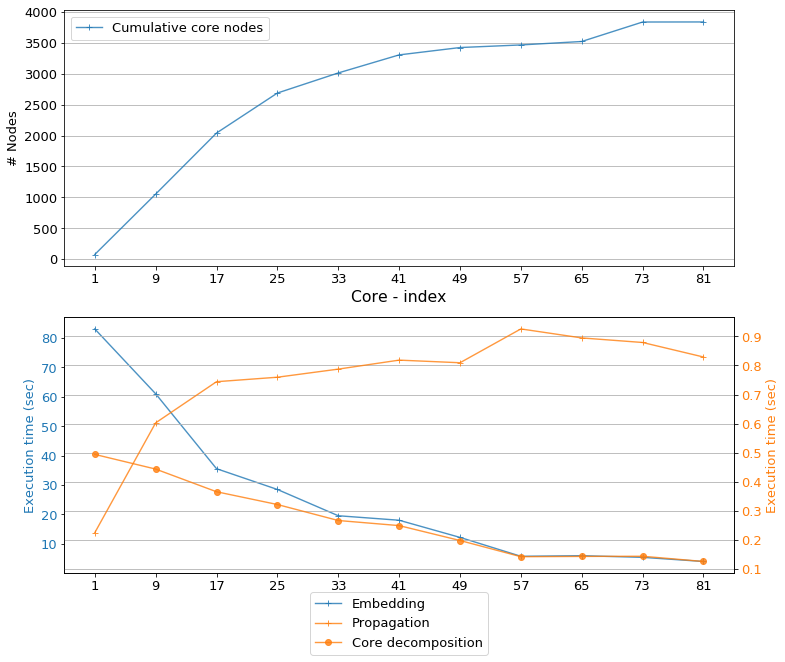

In [145]:
cum_core_nodes = np.array([cum_core_number_fn(k) for k in range(1, max_core_index+1)])[np.array(sorted(core_index))-1]

plt.figure(figsize=(12, 16))
plt.subplot(3, 1, 1)

plt.plot(sorted(core_index), cum_core_nodes, marker="+", alpha=.8, lw=1.4, label = "Cumulative core nodes")

plt.ylabel("# Nodes")
plt.xlabel("Core - index", fontsize="large")
plt.legend()
plt.xticks(core_index)
plt.gca().yaxis.grid(True)

ax1 = plt.subplot(3, 1, 2)
l1 = ax1.plot(sorted(core_index), np.array(embed_time)[np.argsort(core_index)], marker="+", alpha=.8, lw=1.4, label = "Embedding")
ax1.set_ylabel("Execution time (sec)", color="C0")
ax1.tick_params(axis='y', labelcolor="C0")

ax2 = ax1.twinx()

ax2.set_ylabel("Execution time (sec)", color="C1")
l2 = ax2.plot(sorted(core_index), np.array(propag_time)[np.argsort(core_index)], marker="+", alpha=.8, lw=1.4, label = "Propagation", color="C1")
l3 = ax2.plot(sorted(core_index), np.array(core_dec_time)[np.argsort(core_index)], marker="o", alpha=.8, lw=1.4, label = "Core decomposition", color="C1")
ax2.tick_params(axis='y', labelcolor="C1")
plt.xlabel("Core - index", fontsize="large")
plt.xticks(core_index)
lns = l1 + l2 + l3
labels = [l.get_label() for l in lns]
ax1.legend(lns, labels, loc='upper center', bbox_to_anchor=(0.5, -0.05))
plt.gca().yaxis.grid(True)

plt.savefig(fname_fn("facebook_30p_exec_time_detail"), dpi=600, bbox_inches="tight")

plt.show()

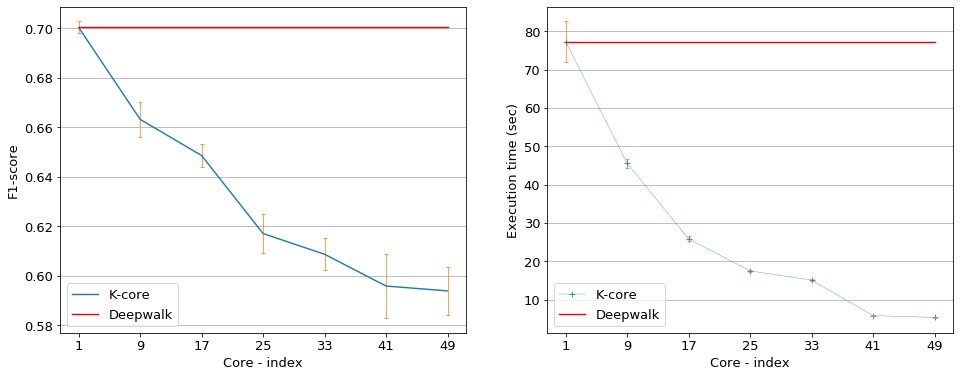

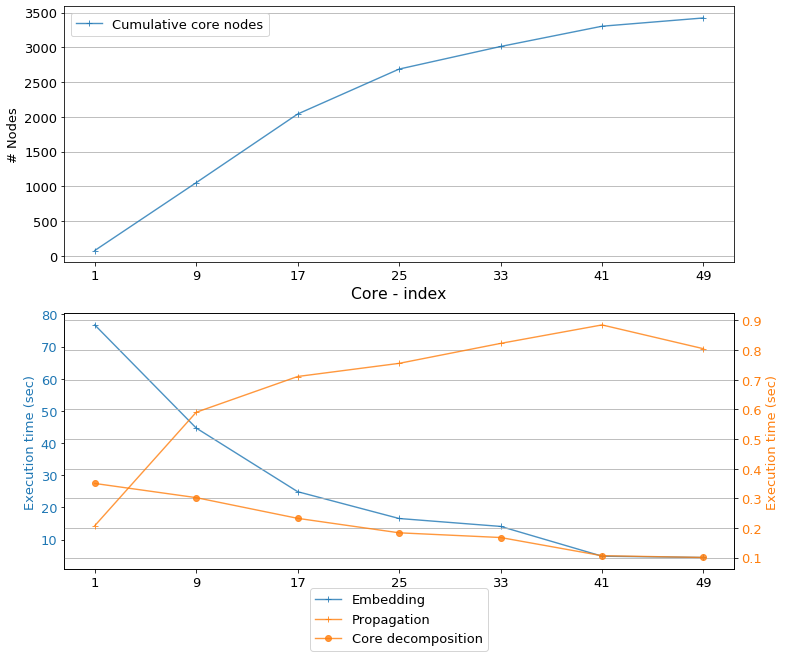

In [146]:
# Link prediction - Cut ratio 50%

exp_names = [x for x in os.listdir(SAVE_PATH) if re.match(graph_name+"_k_core*", x)]

core_index = []
f1_score = []
f1_score_std = []
exec_time = []
exec_time_std = []
cut_ratio = []
core_dec_time = []
propag_time = []
embed_time = []

for exp_name in exp_names :
    try :
        params = get_emb_params(SAVE_PATH, exp_name)
        results = get_exp_results(SAVE_PATH, exp_name)
        config = get_config_params(SAVE_PATH, exp_name)
        cut_ratio_ = config["downstream_task_args"]["cut_ratio"]
        if cut_ratio_ != .5:
            continue
        cut_ratio.append(cut_ratio_)
        core_index.append(params["train"]["core_index"])
        f1_score.append(results["macro_f1"].mean())
        f1_score_std.append(results["macro_f1"].std())
        
        exec_time.append(results["exec_times"].apply(lambda x: x["total"]).mean())
        exec_time_std.append(results["exec_times"].apply(lambda x: x["total"]).std())
        
        core_dec_time.append(results["exec_times"].apply(lambda x: x["k_core"]).mean())
        propag_time.append(results["exec_times"].apply(lambda x: x["propagate"]).mean())
        embed_time.append(results["exec_times"].apply(lambda x: x["embed"]).mean())
        
    except FileNotFoundError:
        pass
        

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)

error_plot_args = {"alpha":.8, "lw":0, "marker":"", "elinewidth":.9, "capsize":2}
plt.plot(sorted(core_index), np.array(f1_score)[np.argsort(core_index)], label = "K-core", lw=1.4)
plt.errorbar(sorted(core_index), np.array(f1_score)[np.argsort(core_index)], yerr=np.array(f1_score_std)[np.argsort(core_index)], **error_plot_args)
plt.plot(sorted(core_index), [np.array(f1_score)[np.argsort(core_index)][0]]*len(core_index), label="Deepwalk", lw=1.4, c="r")
plt.ylabel("F1-score")
plt.xlabel("Core - index")
plt.legend()
plt.xticks(core_index)
plt.gca().yaxis.grid(True)

plt.subplot(1, 2, 2)

plt.plot(sorted(core_index), np.array(exec_time)[np.argsort(core_index)], marker="+", alpha=.8, lw=.4, label = "K-core")
plt.errorbar(sorted(core_index), np.array(exec_time)[np.argsort(core_index)], yerr=np.array(exec_time_std)[np.argsort(core_index)], **error_plot_args)
plt.plot(sorted(core_index), [np.array(exec_time)[np.argsort(core_index)][0]]*len(core_index), label="Deepwalk", lw=1.4, c="r")
plt.ylabel("Execution time (sec)")
plt.xlabel("Core - index")
plt.legend()
plt.xticks(core_index)
plt.gca().yaxis.grid(True)
plt.savefig(fname_fn("facebook_50p_f1_exec"), dpi=600, bbox_inches="tight")

plt.show()

cum_core_nodes = np.array([cum_core_number_fn(k) for k in range(1, max_core_index+1)])[np.array(sorted(core_index))-1]

plt.figure(figsize=(12, 16))
plt.subplot(3, 1, 1)

plt.plot(sorted(core_index), cum_core_nodes, marker="+", alpha=.8, lw=1.4, label = "Cumulative core nodes")

plt.ylabel("# Nodes")
plt.xlabel("Core - index", fontsize="large")
plt.legend()
plt.xticks(core_index)
plt.gca().yaxis.grid(True)

ax1 = plt.subplot(3, 1, 2)
l1 = ax1.plot(sorted(core_index), np.array(embed_time)[np.argsort(core_index)], marker="+", alpha=.8, lw=1.4, label = "Embedding")
ax1.set_ylabel("Execution time (sec)", color="C0")
ax1.tick_params(axis='y', labelcolor="C0")

ax2 = ax1.twinx()

ax2.set_ylabel("Execution time (sec)", color="C1")
l2 = ax2.plot(sorted(core_index), np.array(propag_time)[np.argsort(core_index)], marker="+", alpha=.8, lw=1.4, label = "Propagation", color="C1")
l3 = ax2.plot(sorted(core_index), np.array(core_dec_time)[np.argsort(core_index)], marker="o", alpha=.8, lw=1.4, label = "Core decomposition", color="C1")
ax2.tick_params(axis='y', labelcolor="C1")
plt.xlabel("Core - index", fontsize="large")
plt.xticks(core_index)
lns = l1 + l2 + l3
labels = [l.get_label() for l in lns]
ax1.legend(lns, labels, loc='upper center', bbox_to_anchor=(0.5, -0.05))
plt.gca().yaxis.grid(True)

plt.savefig(fname_fn("facebook_50p_exec_time_detail"), dpi=600, bbox_inches="tight")

plt.show()

# Node classification

In [42]:
exp_names = ["cora_deepwalk_k_core_2020-02-19T15-32-25_0", "cora_deepwalk_k_core_2020-02-19T15-43-16_0", "cora_deepwalk_k_core_2020-02-19T15-46-47_0", "cora_deepwalk_k_core_2020-02-19T15-49-38_0"]

core_index = []
target_f1_score = []
baseline_f1_score = []
target_exec_time = []
baseline_exec_time = []

for exp_name in exp_names :
    params = get_exp_params(SAVE_PATH, exp_name)
    target_results = get_exp_target_results(SAVE_PATH, exp_name)
    baseline_results = get_exp_baseline_results(SAVE_PATH, exp_name)
    
    core_index.append(params["train"]["core_index"])
    target_f1_score.append(target_results["macro_f1"].mean())
    target_exec_time.append(target_results["exec_times"].apply(lambda time_dict : eval(time_dict)["total"]).mean())
    baseline_f1_score.append(baseline_results["macro_f1"].mean())
    baseline_exec_time.append(baseline_results["exec_times"].apply(lambda time_dict : eval(time_dict)["total"]).mean())

NameError: name 'get_exp_params' is not defined

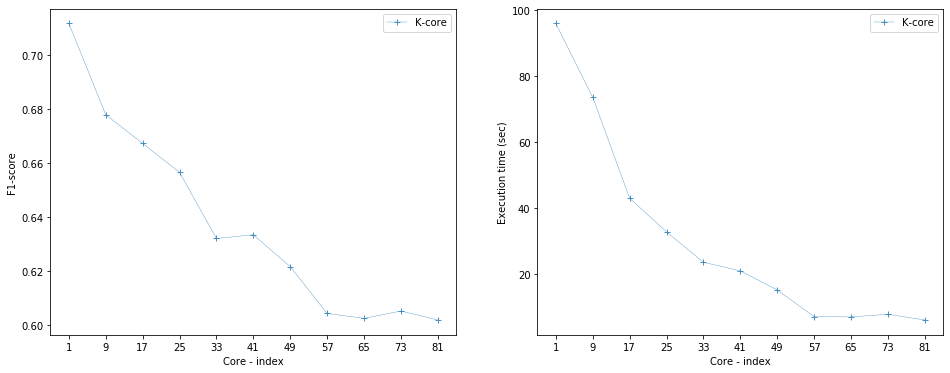

In [38]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)

plt.plot(sorted(core_index), np.array(f1_score)[np.argsort(core_index)], marker="+", alpha=.8, lw=.4, label = "K-core")
plt.ylabel("F1-score")
plt.xlabel("Core - index")
plt.legend()
plt.xticks(core_index)

plt.subplot(1, 2, 2)

plt.plot(sorted(core_index), np.array(exec_time)[np.argsort(core_index)], marker="+", alpha=.8, lw=.4, label = "K-core")
plt.ylabel("Execution time (sec)")
plt.xlabel("Core - index")
plt.legend()
plt.xticks(core_index)
plt.show()

## Embedding

In [125]:
exp_names = ["cora_deepwalk_k_core_2020-02-19T15-32-25_0", "cora_deepwalk_k_core_2020-02-19T15-43-16_0", "cora_deepwalk_k_core_2020-02-19T15-46-47_0", "cora_deepwalk_k_core_2020-02-19T15-49-38_0"]

core_index = []
target_f1_score = []
baseline_f1_score = []
target_exec_time = []
baseline_exec_time = []

for exp_name in exp_names :
    params = get_exp_params(SAVE_PATH, exp_name)
    target_results = get_exp_target_results(SAVE_PATH, exp_name)
    baseline_results = get_exp_baseline_results(SAVE_PATH, exp_name)
    
    core_index.append(params["train"]["core_index"])
    target_f1_score.append(target_results["macro_f1"].mean())
    target_exec_time.append(target_results["exec_times"].apply(lambda time_dict : eval(time_dict)["total"]).mean())
    baseline_f1_score.append(baseline_results["macro_f1"].mean())
    baseline_exec_time.append(baseline_results["exec_times"].apply(lambda time_dict : eval(time_dict)["total"]).mean())

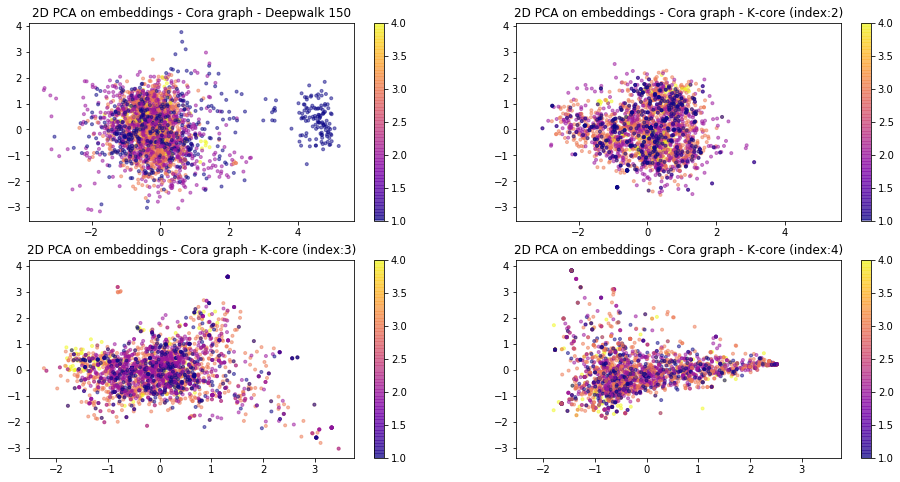

In [126]:
target_emb, base_emb = get_embedding(SAVE_PATH, exp_name)
graph = nx.read_gml(DATA_PATH)
core_numbers = nx.core_number(graph)

core_index = []
target_emb_list, base_emb_list = [], []
for exp_name in exp_names :
    params = get_exp_params(SAVE_PATH, exp_name)
    core_index.append(params["train"]["core_index"])
    target_emb, base_emb = get_embedding(SAVE_PATH, exp_name)
    target_emb_list.append(target_emb)
    base_emb_list.append(base_emb)

fig = plt.figure(figsize=(16, 8))
ax = plt.subplot(221)
vectors, node2id, id2node = base_emb.values()
plot_emb_core(vectors, id2node, core_numbers, min_core=0)  #, min_core=0, max_core=114)
plt.title("2D PCA on embeddings - Cora graph - Deepwalk 150")
plt.subplot(222, sharex=ax, sharey=ax)
vectors, node2id, id2node = target_emb_list[1].values()
plot_emb_core(vectors, id2node, core_numbers, min_core=0)
plt.title("2D PCA on embeddings - Cora graph - K-core (index:{})".format(core_index[1]))
ax = plt.subplot(223)
vectors, node2id, id2node = target_emb_list[2].values()
plot_emb_core(vectors, id2node, core_numbers, min_core=0)  #, min_core=0, max_core=114)
plt.title("2D PCA on embeddings - Cora graph - K-core (index:{})".format(core_index[2]))
plt.subplot(224, sharex=ax, sharey=ax)
vectors, node2id, id2node = target_emb_list[3].values()
plot_emb_core(vectors, id2node, core_numbers, min_core=0)
plt.title("2D PCA on embeddings - Cora graph - K-core (index:{})".format(core_index[3]))
plt.show()

In [ ]:
target_emb, base_emb = get_embedding(SAVE_PATH, exp_name)
graph = nx.read_gml(DATA_PATH)
core_numbers = nx.core_number(graph)

core_index = []
target_emb_list, base_emb_list = [], []
for exp_name in exp_names :
    params = get_exp_params(SAVE_PATH, exp_name)
    core_index.append(params["train"]["core_index"])
    target_emb, base_emb = get_embedding(SAVE_PATH, exp_name)
    target_emb_list.append(target_emb)
    base_emb_list.append(base_emb)

fig = plt.figure(figsize=(16, 8))
ax = plt.subplot(221)
vectors, node2id, id2node = base_emb.values()
plot_emb_core(vectors, id2node, core_numbers, min_core=0)  #, min_core=0, max_core=114)
plt.title("2D PCA on embeddings - Cora graph - Deepwalk 150")
plt.subplot(222, sharex=ax, sharey=ax)
vectors, node2id, id2node = target_emb_list[1].values()
plot_emb_core(vectors, id2node, core_numbers, min_core=0)
plt.title("2D PCA on embeddings - Cora graph - K-core (index:{})".format(core_index[1]))
ax = plt.subplot(223)
vectors, node2id, id2node = target_emb_list[2].values()
plot_emb_core(vectors, id2node, core_numbers, min_core=0)  #, min_core=0, max_core=114)
plt.title("2D PCA on embeddings - Cora graph - K-core (index:{})".format(core_index[2]))
plt.subplot(224, sharex=ax, sharey=ax)
vectors, node2id, id2node = target_emb_list[3].values()
plot_emb_core(vectors, id2node, core_numbers, min_core=0)
plt.title("2D PCA on embeddings - Cora graph - K-core (index:{})".format(core_index[3]))
plt.show()

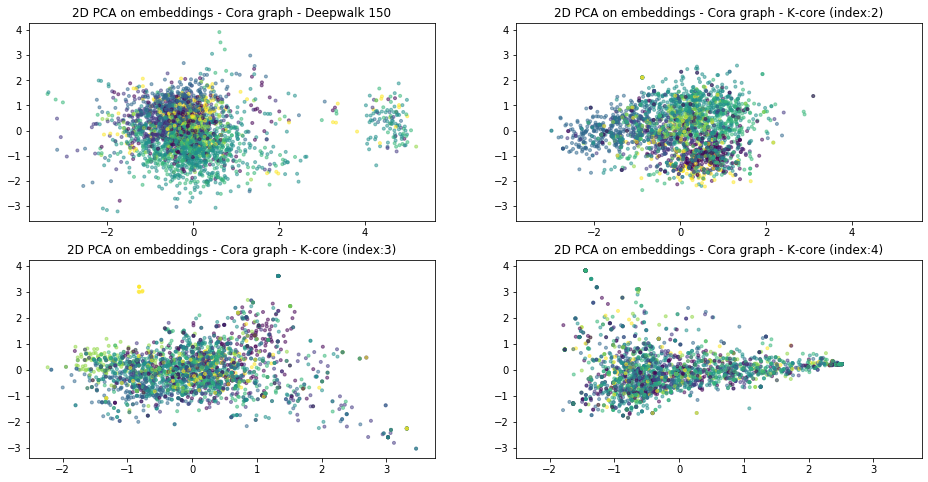

In [156]:
target_emb, base_emb = get_embedding(SAVE_PATH, exp_name)
graph = nx.read_gml(DATA_PATH)
core_numbers = nx.core_number(graph)

core_index = []
target_emb_list, base_emb_list = [], []
for exp_name in exp_names :
    params = get_exp_params(SAVE_PATH, exp_name)
    core_index.append(params["train"]["core_index"])
    target_emb, base_emb = get_embedding(SAVE_PATH, exp_name)
    target_emb_list.append(target_emb)
    base_emb_list.append(base_emb)

fig = plt.figure(figsize=(16, 8))
ax = plt.subplot(221)
vectors, node2id, id2node = base_emb.values()
plot_emb_core_class(vectors, id2node, core_numbers, min_core=0)  #, min_core=0, max_core=114)
plt.title("2D PCA on embeddings - Cora graph - Deepwalk 150")
plt.subplot(222, sharex=ax, sharey=ax)
vectors, node2id, id2node = target_emb_list[1].values()
plot_emb_core_class(vectors, id2node, core_numbers, min_core=0)
plt.title("2D PCA on embeddings - Cora graph - K-core (index:{})".format(core_index[1]))
ax = plt.subplot(223)
vectors, node2id, id2node = target_emb_list[2].values()
plot_emb_core_class(vectors, id2node, core_numbers, min_core=0)  #, min_core=0, max_core=114)
plt.title("2D PCA on embeddings - Cora graph - K-core (index:{})".format(core_index[2]))
plt.subplot(224, sharex=ax, sharey=ax)
vectors, node2id, id2node = target_emb_list[3].values()
plot_emb_core_class(vectors, id2node, core_numbers, min_core=0)
plt.title("2D PCA on embeddings - Cora graph - K-core (index:{})".format(core_index[3]))
plt.show()

# The famous road graph dataset

In [159]:
exp_name = "roads_20000_deepwalk_corewalk_linear_2020-02-19T14-50-44_0"
params = get_exp_params(SAVE_PATH, exp_name)
target_results = get_exp_target_results(SAVE_PATH, exp_name)
baseline_results = get_exp_baseline_results(SAVE_PATH, exp_name)

In [169]:
target_results

,out_dim,exec_times,n_walks,walk_length,window_size,n_generated_walks,micro_f1,macro_f1,accuracy,tot_exec_time
0,150,"{'k_core_decomposition': 0.13666868209838867, ...",15,30,5,168965,0.558883,0.558873,0.558883,282.934879
1,150,"{'k_core_decomposition': 1.8296782970428467, '...",15,30,5,169170,0.557257,0.557221,0.557257,282.934879
2,150,"{'k_core_decomposition': 1.8606634140014648, '...",15,30,5,170365,0.557227,0.557215,0.557227,282.934879


In [170]:
baseline_results

,out_dim,exec_times,n_walks,walk_length,window_size,n_generated_walks,micro_f1,macro_f1,accuracy,tot_exec_time
0,150,"{'generate_walks': 168.15657019615173, 'skip_g...",15,30,5,300000,0.540763,0.540760,0.540763,467.934357
1,150,"{'generate_walks': 154.0339035987854, 'skip_gr...",15,30,5,300000,0.545344,0.545339,0.545344,467.934357
2,150,"{'generate_walks': 138.56184124946594, 'skip_g...",15,30,5,300000,0.549483,0.549419,0.549483,467.934357


In [168]:
target_results["tot_exec_time"] = target_results["exec_times"].apply(lambda time_dict : eval(time_dict)["total"]).mean()
baseline_results["tot_exec_time"] = baseline_results["exec_times"].apply(lambda time_dict : eval(time_dict)["total"]).mean()

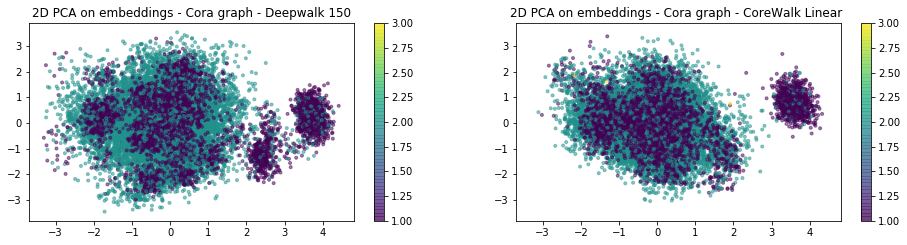

In [175]:
target_emb, base_emb = get_embedding(SAVE_PATH, exp_name)
DATA_PATH_ = "../data/roads_20000.gml"
graph = nx.read_gml(DATA_PATH_)
core_numbers = nx.core_number(graph)

core_index = []
target_emb_list, base_emb_list = [], []

target_emb, base_emb = get_embedding(SAVE_PATH, exp_name)

fig = plt.figure(figsize=(16, 8))
ax = plt.subplot(221)
vectors, node2id, id2node = base_emb.values()
plot_emb_core(vectors, id2node, core_numbers, min_core=0)  #, min_core=0, max_core=114)
plt.title("2D PCA on embeddings - Cora graph - Deepwalk 150")
plt.subplot(222, sharex=ax, sharey=ax)
vectors, node2id, id2node = target_emb.values()
plot_emb_core(vectors, id2node, core_numbers, min_core=0)
plt.title("2D PCA on embeddings - Cora graph - CoreWalk Linear ")
plt.show()

# Github

In [147]:
SAVE_PATH = "../output/cvn_github_experiments"
DATA_PATH = "../data/github.gml"
graph_name = "github"
output_fig = "{}_fig".format(graph_name)

if not os.path.exists(output_fig):
    os.makedirs(output_fig)
else:
    print("Careful, might overwrite")

G = nx.read_gml(DATA_PATH)
print("Graph : ", DATA_PATH)
print("Number of nodes : {}  -  Number of edges : {}\n".format(G.number_of_nodes(), G.number_of_edges()))
kcores = nx.core_number(G)
max_core_index = max(kcores.values())

def fname_fn(name, output_fig=output_fig):
    return os.path.join(os.path.join(output_fig, "{}.png".format(name)))

Careful, might overwrite
Graph :  ../data/github.gml
Number of nodes : 37700  -  Number of edges : 289003



# Link prediction - Cut ratio 10%

In [148]:
exp_names = [x for x in os.listdir(SAVE_PATH) if re.match(graph_name+"_k_core*", x)]

core_index = []
f1_score = []
f1_score_std = []
exec_time = []
exec_time_std = []
core_dec_time = []
propag_time = []
embed_time = []

for exp_name in sorted(exp_names)[:4] :
    try :
        params = get_emb_params(SAVE_PATH, exp_name)
        results = get_exp_results(SAVE_PATH, exp_name)
        config = get_config_params(SAVE_PATH, exp_name)
        cut_ratio.append(cut_ratio_)
        core_index.append(params["train"]["core_index"])
        f1_score.append(results["macro_f1"].mean())
        f1_score_std.append(results["macro_f1"].std())
        
        exec_time.append(results["exec_times"].apply(lambda x: x["total"]).mean())
        exec_time_std.append(results["exec_times"].apply(lambda x: x["total"]).std())
        
        core_dec_time.append(results["exec_times"].apply(lambda x: x["k_core"]).mean())
        propag_time.append(results["exec_times"].apply(lambda x: x["propagate"]).mean())
        embed_time.append(results["exec_times"].apply(lambda x: x["embed"]).mean())
        
    except FileNotFoundError:
        pass       

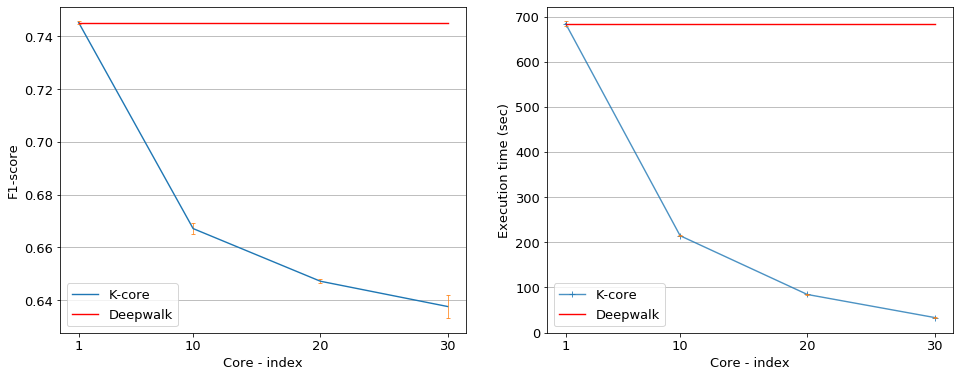

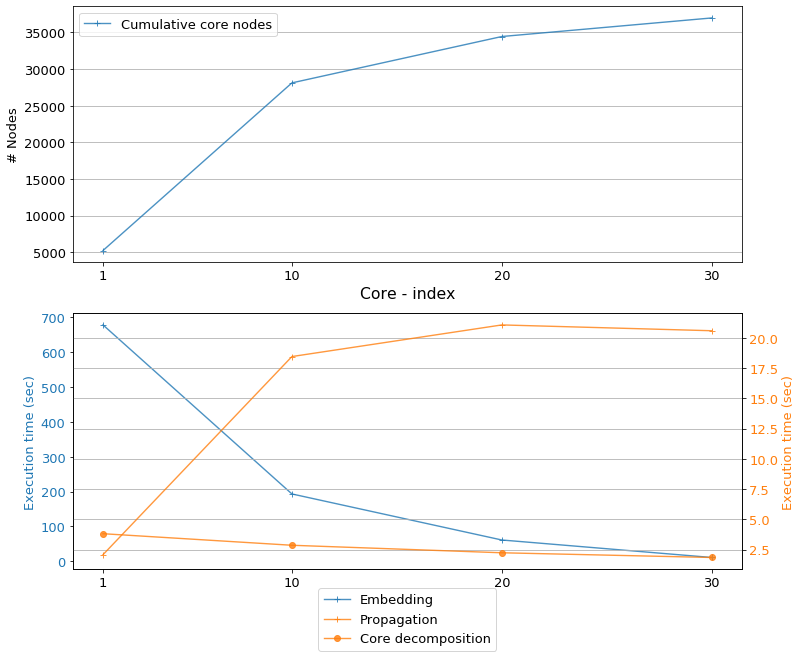

In [149]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)

error_plot_args = {"alpha":.8, "lw":0, "marker":"", "elinewidth":.9, "capsize":2}
plt.plot(sorted(core_index), np.array(f1_score)[np.argsort(core_index)], label = "K-core", lw=1.4)
plt.errorbar(sorted(core_index), np.array(f1_score)[np.argsort(core_index)], yerr=np.array(f1_score_std)[np.argsort(core_index)], **error_plot_args)
plt.plot(sorted(core_index), [np.array(f1_score)[np.argsort(core_index)][0]]*len(core_index), label="Deepwalk", lw=1.4, c="r")
plt.ylabel("F1-score")
plt.xlabel("Core - index")
plt.legend()
plt.xticks(core_index)
plt.gca().yaxis.grid(True)

plt.subplot(1, 2, 2)

plt.plot(sorted(core_index), np.array(exec_time)[np.argsort(core_index)], marker="+", alpha=.8, lw=1.4, label = "K-core")
plt.errorbar(sorted(core_index), np.array(exec_time)[np.argsort(core_index)], yerr=np.array(exec_time_std)[np.argsort(core_index)], **error_plot_args)
plt.plot(sorted(core_index), [np.array(exec_time)[np.argsort(core_index)][0]]*len(core_index), label="Deepwalk", lw=1.4, c="r")
plt.ylabel("Execution time (sec)")
plt.xlabel("Core - index")
plt.legend()
plt.xticks(core_index)
plt.gca().yaxis.grid(True)

plt.savefig(fname_fn("github_10p_f1_exec"), dpi=600, bbox_inches="tight")
plt.show()

cum_core_nodes = np.array([cum_core_number_fn(k) for k in range(1, max_core_index+1)])[np.array(sorted(core_index))-1]

plt.figure(figsize=(12, 16))
plt.subplot(3, 1, 1)

plt.plot(sorted(core_index), cum_core_nodes, marker="+", alpha=.8, lw=1.4, label = "Cumulative core nodes")

plt.ylabel("# Nodes")
plt.xlabel("Core - index", fontsize="large")
plt.legend()
plt.xticks(core_index)
plt.gca().yaxis.grid(True)

ax1 = plt.subplot(3, 1, 2)
l1 = ax1.plot(sorted(core_index), np.array(embed_time)[np.argsort(core_index)], marker="+", alpha=.8, lw=1.4, label = "Embedding")
ax1.set_ylabel("Execution time (sec)", color="C0")
ax1.tick_params(axis='y', labelcolor="C0")

ax2 = ax1.twinx()

ax2.set_ylabel("Execution time (sec)", color="C1")
l2 = ax2.plot(sorted(core_index), np.array(propag_time)[np.argsort(core_index)], marker="+", alpha=.8, lw=1.4, label = "Propagation", color="C1")
l3 = ax2.plot(sorted(core_index), np.array(core_dec_time)[np.argsort(core_index)], marker="o", alpha=.8, lw=1.4, label = "Core decomposition", color="C1")
ax2.tick_params(axis='y', labelcolor="C1")
plt.xlabel("Core - index", fontsize="large")
plt.xticks(core_index)
lns = l1 + l2 + l3
labels = [l.get_label() for l in lns]
ax1.legend(lns, labels, loc='upper center', bbox_to_anchor=(0.5, -0.05))
plt.gca().yaxis.grid(True)

plt.savefig(fname_fn("github_10p_exec_time_detail"), dpi=600, bbox_inches="tight")

plt.show()

# Link prediction 30%

In [150]:
exp_names = [x for x in os.listdir(SAVE_PATH) if re.match(graph_name+"_k_core*", x)]

core_index = []
f1_score = []
f1_score_std = []
exec_time = []
exec_time_std = []
core_dec_time = []
propag_time = []
embed_time = []

for exp_name in sorted(exp_names)[4:] :
    try :
        params = get_emb_params(SAVE_PATH, exp_name)
        results = get_exp_results(SAVE_PATH, exp_name)
        config = get_config_params(SAVE_PATH, exp_name)
        cut_ratio.append(cut_ratio_)
        core_index.append(params["train"]["core_index"])
        f1_score.append(results["macro_f1"].mean())
        f1_score_std.append(results["macro_f1"].std())
        
        exec_time.append(results["exec_times"].apply(lambda x: x["total"]).mean())
        exec_time_std.append(results["exec_times"].apply(lambda x: x["total"]).std())
        
        core_dec_time.append(results["exec_times"].apply(lambda x: x["k_core"]).mean())
        propag_time.append(results["exec_times"].apply(lambda x: x["propagate"]).mean())
        embed_time.append(results["exec_times"].apply(lambda x: x["embed"]).mean())
        
    except FileNotFoundError:
        pass       

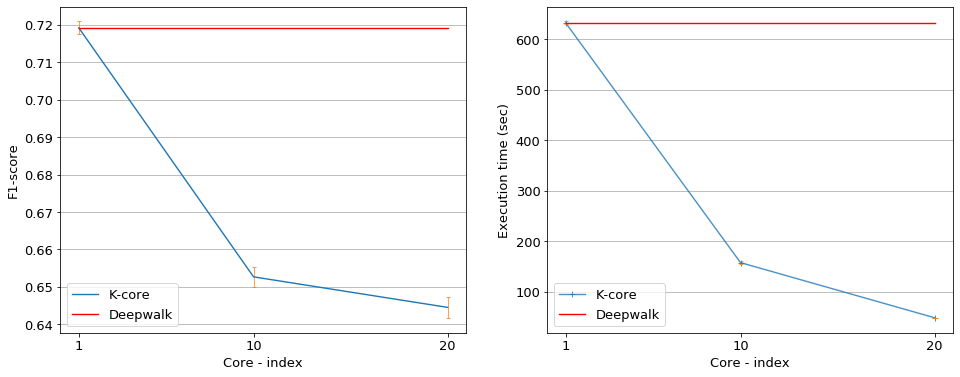

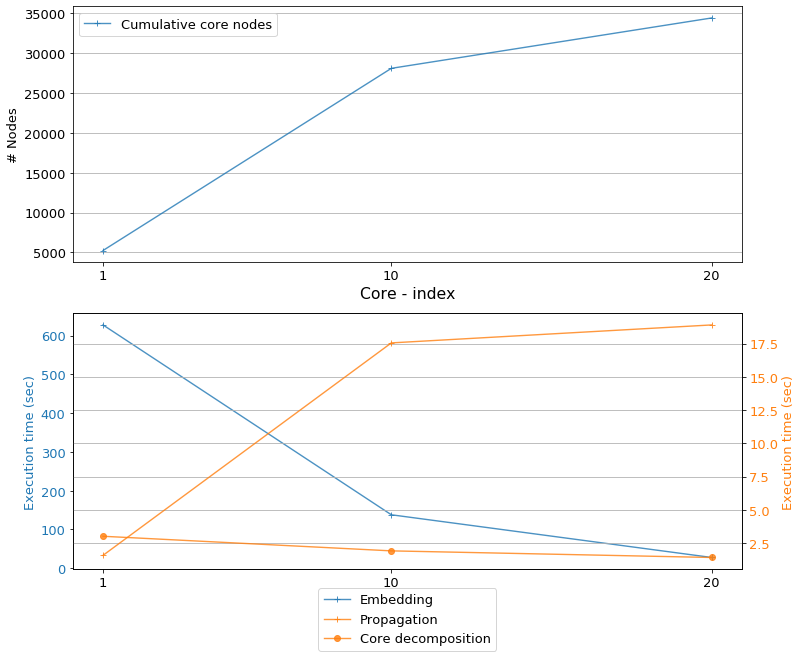

In [151]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)

error_plot_args = {"alpha":.8, "lw":0, "marker":"", "elinewidth":.9, "capsize":2}
plt.plot(sorted(core_index), np.array(f1_score)[np.argsort(core_index)], label = "K-core", lw=1.4)
plt.errorbar(sorted(core_index), np.array(f1_score)[np.argsort(core_index)], yerr=np.array(f1_score_std)[np.argsort(core_index)], **error_plot_args)
plt.plot(sorted(core_index), [np.array(f1_score)[np.argsort(core_index)][0]]*len(core_index), label="Deepwalk", lw=1.4, c="r")
plt.ylabel("F1-score")
plt.xlabel("Core - index")
plt.legend()
plt.xticks(core_index)
plt.gca().yaxis.grid(True)

plt.subplot(1, 2, 2)

plt.plot(sorted(core_index), np.array(exec_time)[np.argsort(core_index)], marker="+", alpha=.8, lw=1.4, label = "K-core")
plt.errorbar(sorted(core_index), np.array(exec_time)[np.argsort(core_index)], yerr=np.array(exec_time_std)[np.argsort(core_index)], **error_plot_args)
plt.plot(sorted(core_index), [np.array(exec_time)[np.argsort(core_index)][0]]*len(core_index), label="Deepwalk", lw=1.4, c="r")
plt.ylabel("Execution time (sec)")
plt.xlabel("Core - index")
plt.legend()
plt.xticks(core_index)
plt.gca().yaxis.grid(True)

plt.savefig(fname_fn("github_30p_f1_exec"), dpi=600, bbox_inches="tight")
plt.show()

cum_core_nodes = np.array([cum_core_number_fn(k) for k in range(1, max_core_index+1)])[np.array(sorted(core_index))-1]

plt.figure(figsize=(12, 16))
plt.subplot(3, 1, 1)

plt.plot(sorted(core_index), cum_core_nodes, marker="+", alpha=.8, lw=1.4, label = "Cumulative core nodes")

plt.ylabel("# Nodes")
plt.xlabel("Core - index", fontsize="large")
plt.legend()
plt.xticks(core_index)
plt.gca().yaxis.grid(True)

ax1 = plt.subplot(3, 1, 2)
l1 = ax1.plot(sorted(core_index), np.array(embed_time)[np.argsort(core_index)], marker="+", alpha=.8, lw=1.4, label = "Embedding")
ax1.set_ylabel("Execution time (sec)", color="C0")
ax1.tick_params(axis='y', labelcolor="C0")

ax2 = ax1.twinx()

ax2.set_ylabel("Execution time (sec)", color="C1")
l2 = ax2.plot(sorted(core_index), np.array(propag_time)[np.argsort(core_index)], marker="+", alpha=.8, lw=1.4, label = "Propagation", color="C1")
l3 = ax2.plot(sorted(core_index), np.array(core_dec_time)[np.argsort(core_index)], marker="o", alpha=.8, lw=1.4, label = "Core decomposition", color="C1")
ax2.tick_params(axis='y', labelcolor="C1")
plt.xlabel("Core - index", fontsize="large")
plt.xticks(core_index)
lns = l1 + l2 + l3
labels = [l.get_label() for l in lns]
ax1.legend(lns, labels, loc='upper center', bbox_to_anchor=(0.5, -0.05))
plt.gca().yaxis.grid(True)

plt.savefig(fname_fn("github_30p_exec_time_detail"), dpi=600, bbox_inches="tight")

plt.show()

# Cora

In [122]:
SAVE_PATH = "../output/cora_final_experiments"
DATA_PATH = "../data/cora.gml"
graph_name = "cora"
output_fig = "{}_fig".format(graph_name)

if not os.path.exists(output_fig):
    os.makedirs(output_fig)
else:
    print("Careful, might overwrite")

G = nx.read_gml(DATA_PATH)
print("Graph : ", DATA_PATH)
print("Number of nodes : {}  -  Number of edges : {}\n".format(G.number_of_nodes(), G.number_of_edges()))
kcores = nx.core_number(G)
max_core_index = max(kcores.values())

def fname_fn(name, output_fig=output_fig):
    return os.path.join(os.path.join(output_fig, "{}.png".format(name)))

Careful, might overwrite
Graph :  ../data/cora.gml
Number of nodes : 2708  -  Number of edges : 5278



# Link prediction - Cut ratio 10%

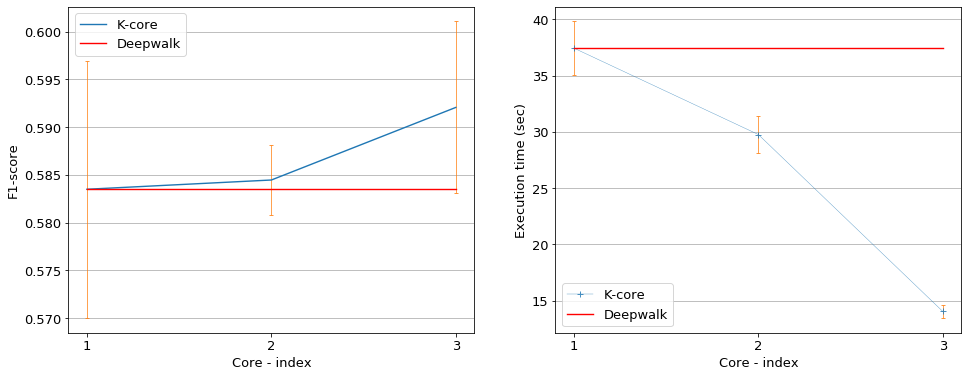

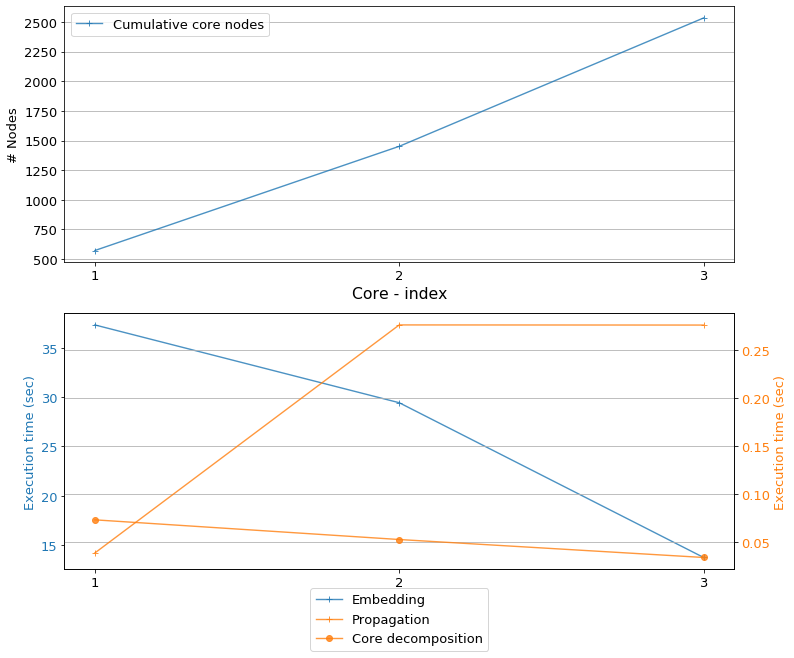

In [126]:
exp_names = [x for x in os.listdir(SAVE_PATH) if re.match(graph_name+"_k_core*", x)]

core_index = []
f1_score = []
f1_score_std = []
exec_time = []
exec_time_std = []
cut_ratio = []
core_dec_time = []
propag_time = []
embed_time = []

for exp_name in exp_names :
    try :
        params = get_emb_params(SAVE_PATH, exp_name)
        results = get_exp_results(SAVE_PATH, exp_name)
        config = get_config_params(SAVE_PATH, exp_name)
        cut_ratio_ = config["downstream_task_args"]["cut_ratio"]
        if cut_ratio_ != .1:
            continue
        cut_ratio.append(cut_ratio_)
        core_index.append(params["train"]["core_index"])
        f1_score.append(results["macro_f1"].mean())
        f1_score_std.append(results["macro_f1"].std())
        
        exec_time.append(results["exec_times"].apply(lambda x: x["total"]).mean())
        exec_time_std.append(results["exec_times"].apply(lambda x: x["total"]).std())
        
        core_dec_time.append(results["exec_times"].apply(lambda x: x["k_core"]).mean())
        propag_time.append(results["exec_times"].apply(lambda x: x["propagate"]).mean())
        embed_time.append(results["exec_times"].apply(lambda x: x["embed"]).mean())
        
    except FileNotFoundError:
        pass
        

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)

error_plot_args = {"alpha":.8, "lw":0, "marker":"", "elinewidth":.9, "capsize":2}
plt.plot(sorted(core_index), np.array(f1_score)[np.argsort(core_index)], label = "K-core", lw=1.4)
plt.errorbar(sorted(core_index), np.array(f1_score)[np.argsort(core_index)], yerr=np.array(f1_score_std)[np.argsort(core_index)], **error_plot_args)
plt.plot(sorted(core_index), [np.array(f1_score)[np.argsort(core_index)][0]]*len(core_index), label="Deepwalk", lw=1.4, c="r")
plt.ylabel("F1-score")
plt.xlabel("Core - index")
plt.legend()
plt.xticks(core_index)
plt.gca().yaxis.grid(True)

plt.subplot(1, 2, 2)

plt.plot(sorted(core_index), np.array(exec_time)[np.argsort(core_index)], marker="+", alpha=.8, lw=.4, label = "K-core")
plt.errorbar(sorted(core_index), np.array(exec_time)[np.argsort(core_index)], yerr=np.array(exec_time_std)[np.argsort(core_index)], **error_plot_args)
plt.plot(sorted(core_index), [np.array(exec_time)[np.argsort(core_index)][0]]*len(core_index), label="Deepwalk", lw=1.4, c="r")
plt.ylabel("Execution time (sec)")
plt.xlabel("Core - index")
plt.legend()
plt.xticks(core_index)
plt.gca().yaxis.grid(True)

plt.savefig(fname_fn("cora_10p_f1_exec"), dpi=600, bbox_inches="tight")
plt.show()


cum_core_nodes = np.array([cum_core_number_fn(k) for k in range(1, max_core_index+1)])[np.array(sorted(core_index))-1]

plt.figure(figsize=(12, 16))
plt.subplot(3, 1, 1)

plt.plot(sorted(core_index), cum_core_nodes, marker="+", alpha=.8, lw=1.4, label = "Cumulative core nodes")

plt.ylabel("# Nodes")
plt.xlabel("Core - index", fontsize="large")
plt.legend()
plt.xticks(core_index)
plt.gca().yaxis.grid(True)

ax1 = plt.subplot(3, 1, 2)
l1 = ax1.plot(sorted(core_index), np.array(embed_time)[np.argsort(core_index)], marker="+", alpha=.8, lw=1.4, label = "Embedding")
ax1.set_ylabel("Execution time (sec)", color="C0")
ax1.tick_params(axis='y', labelcolor="C0")

ax2 = ax1.twinx()

ax2.set_ylabel("Execution time (sec)", color="C1")
l2 = ax2.plot(sorted(core_index), np.array(propag_time)[np.argsort(core_index)], marker="+", alpha=.8, lw=1.4, label = "Propagation", color="C1")
l3 = ax2.plot(sorted(core_index), np.array(core_dec_time)[np.argsort(core_index)], marker="o", alpha=.8, lw=1.4, label = "Core decomposition", color="C1")
ax2.tick_params(axis='y', labelcolor="C1")
plt.xlabel("Core - index", fontsize="large")
plt.xticks(core_index)
lns = l1 + l2 + l3
labels = [l.get_label() for l in lns]
ax1.legend(lns, labels, loc='upper center', bbox_to_anchor=(0.5, -0.05))
plt.gca().yaxis.grid(True)

plt.savefig(fname_fn("cora_10p_exec_time_detail"), dpi=600, bbox_inches="tight")

plt.show()

# # Link prediction - Cut ratio 30%

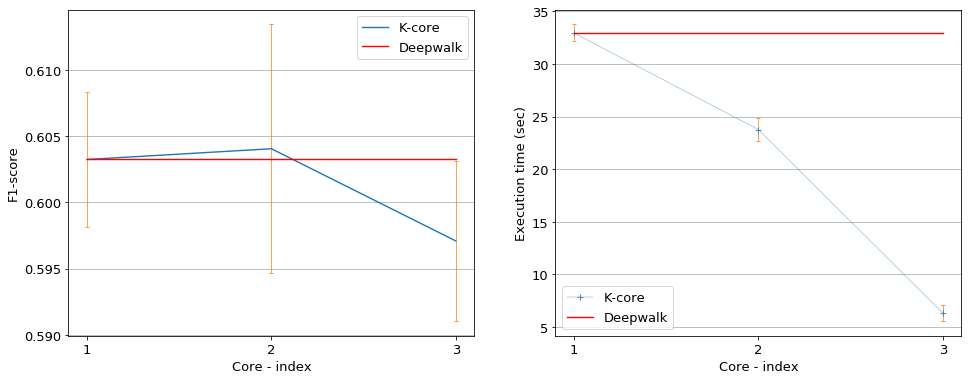

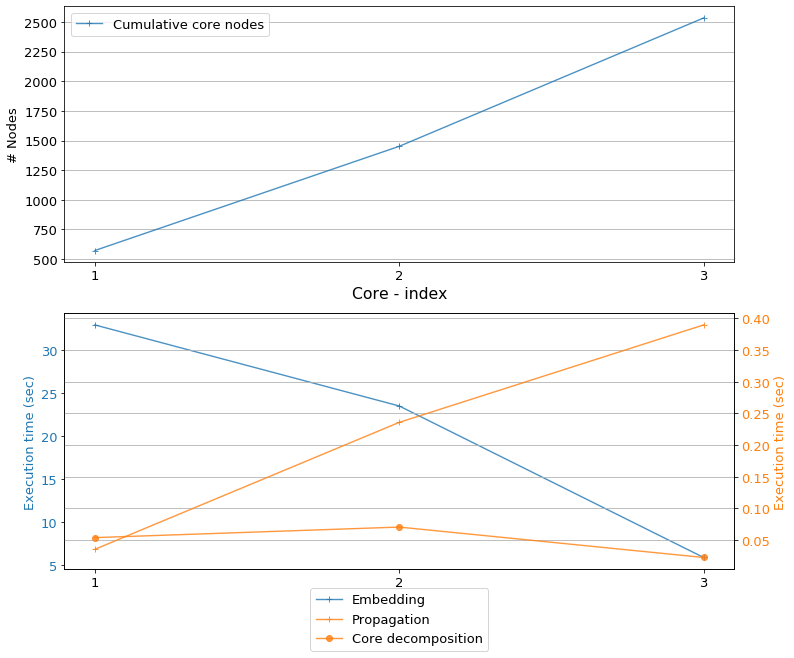

In [127]:
exp_names = [x for x in os.listdir(SAVE_PATH) if re.match(graph_name+"_k_core*", x)]

core_index = []
f1_score = []
f1_score_std = []
exec_time = []
exec_time_std = []
cut_ratio = []
core_dec_time = []
propag_time = []
embed_time = []

for exp_name in exp_names :
    try :
        params = get_emb_params(SAVE_PATH, exp_name)
        results = get_exp_results(SAVE_PATH, exp_name)
        config = get_config_params(SAVE_PATH, exp_name)
        cut_ratio_ = config["downstream_task_args"]["cut_ratio"]
        if cut_ratio_ != .3:
            continue
        cut_ratio.append(cut_ratio_)
        core_index.append(params["train"]["core_index"])
        f1_score.append(results["macro_f1"].mean())
        f1_score_std.append(results["macro_f1"].std())
        
        exec_time.append(results["exec_times"].apply(lambda x: x["total"]).mean())
        exec_time_std.append(results["exec_times"].apply(lambda x: x["total"]).std())
        
        core_dec_time.append(results["exec_times"].apply(lambda x: x["k_core"]).mean())
        propag_time.append(results["exec_times"].apply(lambda x: x["propagate"]).mean())
        embed_time.append(results["exec_times"].apply(lambda x: x["embed"]).mean())
        
    except FileNotFoundError:
        pass
        

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)

error_plot_args = {"alpha":.8, "lw":0, "marker":"", "elinewidth":.9, "capsize":2}
plt.plot(sorted(core_index), np.array(f1_score)[np.argsort(core_index)], label = "K-core", lw=1.4)
plt.errorbar(sorted(core_index), np.array(f1_score)[np.argsort(core_index)], yerr=np.array(f1_score_std)[np.argsort(core_index)], **error_plot_args)
plt.plot(sorted(core_index), [np.array(f1_score)[np.argsort(core_index)][0]]*len(core_index), label="Deepwalk", lw=1.4, c="r")
plt.ylabel("F1-score")
plt.xlabel("Core - index")
plt.legend()
plt.xticks(core_index)
plt.gca().yaxis.grid(True)

plt.subplot(1, 2, 2)

plt.plot(sorted(core_index), np.array(exec_time)[np.argsort(core_index)], marker="+", alpha=.8, lw=.4, label = "K-core")
plt.errorbar(sorted(core_index), np.array(exec_time)[np.argsort(core_index)], yerr=np.array(exec_time_std)[np.argsort(core_index)], **error_plot_args)
plt.plot(sorted(core_index), [np.array(exec_time)[np.argsort(core_index)][0]]*len(core_index), label="Deepwalk", lw=1.4, c="r")
plt.ylabel("Execution time (sec)")
plt.xlabel("Core - index")
plt.legend()
plt.xticks(core_index)
plt.gca().yaxis.grid(True)

plt.savefig(fname_fn("cora_30p_f1_exec"), dpi=600, bbox_inches="tight")
plt.show()


cum_core_nodes = np.array([cum_core_number_fn(k) for k in range(1, max_core_index+1)])[np.array(sorted(core_index))-1]

plt.figure(figsize=(12, 16))
plt.subplot(3, 1, 1)

plt.plot(sorted(core_index), cum_core_nodes, marker="+", alpha=.8, lw=1.4, label = "Cumulative core nodes")

plt.ylabel("# Nodes")
plt.xlabel("Core - index", fontsize="large")
plt.legend()
plt.xticks(core_index)
plt.gca().yaxis.grid(True)

ax1 = plt.subplot(3, 1, 2)
l1 = ax1.plot(sorted(core_index), np.array(embed_time)[np.argsort(core_index)], marker="+", alpha=.8, lw=1.4, label = "Embedding")
ax1.set_ylabel("Execution time (sec)", color="C0")
ax1.tick_params(axis='y', labelcolor="C0")

ax2 = ax1.twinx()

ax2.set_ylabel("Execution time (sec)", color="C1")
l2 = ax2.plot(sorted(core_index), np.array(propag_time)[np.argsort(core_index)], marker="+", alpha=.8, lw=1.4, label = "Propagation", color="C1")
l3 = ax2.plot(sorted(core_index), np.array(core_dec_time)[np.argsort(core_index)], marker="o", alpha=.8, lw=1.4, label = "Core decomposition", color="C1")
ax2.tick_params(axis='y', labelcolor="C1")
plt.xlabel("Core - index", fontsize="large")
plt.xticks(core_index)
lns = l1 + l2 + l3
labels = [l.get_label() for l in lns]
ax1.legend(lns, labels, loc='upper center', bbox_to_anchor=(0.5, -0.05))
plt.gca().yaxis.grid(True)

plt.savefig(fname_fn("cora_30p_exec_time_detail"), dpi=600, bbox_inches="tight")

plt.show()